IMPORTAR RECURSOS

In [ ]:
from stop_words import get_stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sentiment_analysis_spanish import sentiment_analysis
from nltk.corpus import wordnet
from functions import *
from getTweets import *
from processTopic import *
from entidades import find_entities
import pandas as pd
import numpy as np
import operator

# **Obtener Tweets**

In [3]:
# Obtener trends
trends = getTrend()
print(trends)

[✓] Trends successfully extracted.
['#BTSxWeAreUnderTheSameMoon', '#GetWellSoonJINJIN', '#LaVozSenior', '#ReinasDelShow', '#祝你生日快樂威珍妮', 'Advincula', 'Austria', 'Barcos', 'CELAC', 'Cantinflas', 'Castillo', 'Cateriano', 'Checho', 'Chelsea', 'Corzo', 'Cristiano Ronaldo', 'Cuba', 'De Gea', 'FIRST AND ONLY V', 'Flor de Retama', 'HAVE A SAFE FLIGHT', 'HYPNOTIZED BY ITZY', 'Hildebrandt', 'Hume', 'Keiko', 'Lilia Paredes', 'Lingard', 'Lora', 'Lukaku', 'Maeve', 'Manchester United', 'Mora', 'México', 'Nicaragua', 'Noble', 'Otis', 'PROUD OF YOU LALISA', 'Premier League', 'Ruby', 'Shaw', 'Taperiano', 'Tottenham', 'Uruguay', 'Virginia', 'West Ham', 'Yotun', 'kcon', 'primera dama', 'privacidad', 'yixing']


In [4]:
# # Obtener tweets
get_tweets_tweepy("Cristiano Ronaldo")

[✓] 500 tweets received about Cristiano Ronaldo


# **Crear Noticia**

## Leer trend en json

In [5]:
trend_path = 'tweets\Cristiano Ronaldo.json'
trend_name = trend_path.split('\\')[-1].split('.')[0]
data = pd.read_json(trend_path, lines=True)
data.head()

,id,text,screen_name,user_followers,retweet_count,favorite_count,date,language,img
0,1439584286143926272,➤ Primer partido desde que volvió al United: D...,InvictosSomos,797457,698,4840,2021-09-19 13:36:54,es,http://pbs.twimg.com/media/E_puOLmXoAcOQWm.jpg
1,1439585542291738624,Cristiano Ronaldo desde que regresó al United:...,InvictosSomos,797457,431,3201,2021-09-19 13:41:54,es,http://pbs.twimg.com/media/E_pvZTkWEAM1eLR.jpg
2,1439571313119596544,🇵🇹 Cristiano Ronaldo\n🇫🇷 Paul Labile Pogba\n\n...,ManUtd_Es,1062972,75,2004,2021-09-19 12:45:21,es,http://pbs.twimg.com/media/E_ph5L9WUAknQlJ.jpg
3,1439638084526747648,PES 2022 ppsspp jugamos con el manchester unit...,mundoxretro1,7,0,0,2021-09-19 17:10:41,es,
4,1439637445893574656,¡UNITED SIGUE LÍDER! 🤩 🔝 \n\n@ManUtd_Es le gan...,DC4TCS,12619,0,0,2021-09-19 17:08:08,es,http://pbs.twimg.com/media/E_qen2lXsAQcVoY.jpg


## Limpieza de datos

In [6]:
data_clean = clean_data(trend_path)
#data_clean.head()

## Palabras de mayor importancia - Count Vectorizer

In [7]:
# Definir stopwords
stop_word_es = get_stop_words('spanish')
def find_top_words(data):
    # contabilizar frecuencias mediante CV
    cv = CountVectorizer(stop_words= stop_word_es)
    cv_matrix = cv.fit_transform(data['text'])
    count_words = np.sum(cv_matrix.toarray(), axis=0)
    words_cv =  {key:count_words[cv.vocabulary_[key]] for key in cv.vocabulary_}
    top_words_cv = sorted(words_cv.items(), key=operator.itemgetter(1), reverse=True)

    # contabilizar frecuencia mediante IDF
    tfidf = TfidfTransformer()
    tfidf_matrix = tfidf.fit_transform(cv_matrix)
    words_idf =  dict(zip(cv.get_feature_names(), tfidf.idf_))
    top_words_idf =  sorted(words_idf.items(), key=operator.itemgetter(1), reverse=True)
    return top_words_cv, top_words_idf

In [8]:
cv, idf = find_top_words(data_clean)

## Clasidicacion mediante glosarios

In [9]:
# Cargar glosarios
glossaries = {}
with os.scandir('glossaries') as gloss_scanIte:
    for dir in gloss_scanIte:
        tmp = open(dir, 'r').readlines()
        lines = [ without_accents(word.rsplit('\n')[0]) for word in tmp]
        name = dir.path.split('\\')[-1].split('.')[0]
        glossaries[name] = lines

        # crear archivo output
        file = open('results/' + name + '.json', 'a')
        file.close()

# Identificar categoria del trend 
points = {}
words_found = {}
for key in glossaries:
    count = 0
    tmp = []
    for word, score in cv:
        if word in glossaries[key]:
            tmp.append(word)
            count += score
    points[key] = count
    words_found[key] = tmp
category = sorted(points.items(), key=operator.itemgetter(1), reverse=True)[0][0]
category

'deportes'

In [68]:
words_found

{'deportes': [],
 'economia': [],
 'entretenimiento': ['bts', 'viaje', 'entrevista', 'arte', 'musica'],
 'espectaculos': ['numero', 'arte', 'concierto'],
 'politica': ['poder', 'justicia', 'ley'],
 'salud': ['corazon', 'salud', 'dolor']}

In [69]:
points

{'deportes': 0,
 'economia': 0,
 'entretenimiento': 382,
 'espectaculos': 3,
 'politica': 16,
 'salud': 17}

## Identificacion de titular

In [88]:
data_top_by_favorite = data.sort_values('favorite_count', ascending=False)
data_top_by_favorite.iloc[0,1]

'Spiderman 2 y God of War Ragnarok, suficientes razones para comprarme una ps5 https://t.co/xqxC5ADOPU'

In [89]:
data_top_by_user_followers = data.sort_values('user_followers', ascending=False)
data_top_by_user_followers.iloc[0,1]

'¡WE. ARE. VENOM!\n\n#SpiderMan2 llegará con Miles y Peter enfrentándose a Venom en la esperada secuela del afamado juego de SpiderMan. ¿Están emocionados? Llega en 2023 https://t.co/T4OSFTdeZ3'

In [90]:
data_top_by_retweet_count = data.sort_values('retweet_count', ascending=False)
data_top_by_retweet_count.iloc[0,1]

'Spiderman 2 y God of War Ragnarok, suficientes razones para comprarme una ps5 https://t.co/xqxC5ADOPU'

In [91]:
data_score = data.copy()
data_score['score'] = data_score['user_followers'] * data_score['retweet_count'] * data_score['favorite_count']
data_score_top_by_score = data_score.sort_values('score', ascending=False)
data_score_top_by_score.iloc[0,1]

'OFICIAL: #Sony confirma que #InsomniacGames está trabajando en la secuela del videojuego de #Spiderman de 2018, con #Venom como villano, el juego sera exclusivo para el #PlayStation 🕷️ https://t.co/Z6qAEsMyn8'

## Identificar entidades

In [18]:
# Prepocesar
data_clean_by_enti = data.copy()
data_clean_by_enti['text'] = data_clean_by_enti['text'].apply(clean_text_for_enti)

# entidades
entities = find_entities(data_clean_by_enti)

# procesar entidades
top_entities =  sorted(entities.items(), key=operator.itemgetter(1), reverse=True)[:10]

# Encontrar significado
dic_entities = {}
for entity in top_entities:
    dic_entities[entity[0]] = find_mean(entity[0])

In [ ]:
def get_top_entities(data_clean_for_enti):
    # preprocesar
    data_clean_for_enti['text'] = data_clean_for_enti['text'].apply(clean_text_for_enti)

    # encontrar entidades
    entities = find_entities(data_clean_by_enti)

    # procesar entidades
    top_entities =  sorted(entities.items(), key=operator.itemgetter(1), reverse=True)[:10]

    # Encontrar significado
    dic_entities = {}
    for entity in top_entities:
        dic_entities[entity[0]] = find_mean(entity[0])
    return dic_entities


## Analisis de Sentimientos

In [28]:
from nltk.tokenize import word_tokenize
from nltk import pos_tag
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}
def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))
    newlist = []
    for word, tag in tags:
        #if word.lower() not in set(stopwords.words('spanish')):
        newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return newlist


In [ ]:
data_pos_tag =  data_clean.copy()
data_pos_tag['POS tagged'] = data_pos_tag['text'].apply()
data_pos_tag = data_pos_tag.drop(['id', 'img', 'date', 'retweet_count', 'screen_name', 'language', 'favorite_count', 'user_followers'], axis=1)
data_pos_tag.iloc[2,1]

In [12]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\intel\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [15]:
def SentimentAnalysis(polarity):
  polarity=float(polarity)
  if polarity<0.2:
    return "Temor"
  elif polarity>0.2 and polarity<-0.4:
    return "Preocupación"
  elif polarity>-0.4 and polarity<0.6:
    return "Neutral"
  elif polarity>0.6 and polarity<0.8:
    return "Optimismo"
  else:
    return "Alegría"

In [16]:
data_sentiment = data_clean.copy()
sentiment = sentiment_analysis.SentimentAnalysisSpanish()
data_sentiment['Polarity'] = data_sentiment['text'].apply(sentiment.sentiment) 
data_sentiment['Analysis'] = data_sentiment['Polarity'].apply(SentimentAnalysis)
data_sentiment.head()

,id,text,screen_name,user_followers,retweet_count,favorite_count,date,language,img,Polarity,Analysis
0,1439348580137975808,bien dicen que el enemigo principal siempre es...,CartoonLA,110356,548,2295,2021-09-18 22:00:17,es,http://pbs.twimg.com/media/E_mX59ZWYAAdAWe.png,0.003758,Temor
1,1439195783291719680,pues si es el batmanday y se pueden hacer cosa...,ClaudioSensasao,44195,239,1115,2021-09-18 11:53:08,es,http://pbs.twimg.com/ext_tw_video_thumb/143919...,0.004348,Temor
2,1438982925404545024,para conmemorar batmanday manana hbomaxla lanz...,GabyMeza8,229149,396,3797,2021-09-17 21:47:19,es,http://pbs.twimg.com/media/E_hLU-PXEAAz9jc.jpg,0.007224,Temor
3,1439577739523235840,hola a otro domingo azul en la ciudad the door...,mexicocityblues,217,0,0,2021-09-19 13:10:53,es,http://pbs.twimg.com/media/E_poTBpX0AA8Iz2.jpg,0.666602,Optimismo
4,1439575283737243648,batmanday alertasismica todo en una sola esce...,RayoVen,4650,0,0,2021-09-19 13:01:08,es,http://pbs.twimg.com/ext_tw_video_thumb/143957...,0.982905,Alegría


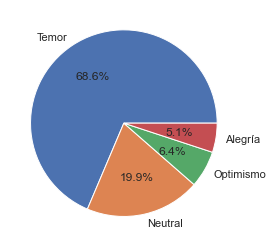

In [17]:
tb_counts = data_sentiment.Analysis.value_counts()
tb_count= data_sentiment.Analysis.value_counts()
#plt.figure(figsize=(10, 7))
aux = plt.pie(tb_counts.values, labels = tb_counts.index, autopct='%1.1f%%', shadow=False)

## Construccion del .json - output

In [19]:
new = {}
new['title'] = str(data_score_top_by_score.iloc[0,1])
new['date'] = str(data_top_by_user_followers.iloc[0,6])
new['img'] = str(data_top_by_user_followers.iloc[0,8])
new['category'] = str(category)
new['entities'] = dic_entities

In [21]:
with open('results/'+ category + '.json', 'a', encoding='utf-8') as file:
    json.dump(new, file, indent=4)